<img src="QuSCo_Logo_CMYK.jpg" alt="Here should be the qusco logo!" width="500">

---

In [1]:
import qutip
import numpy as np
import scipy
import matplotlib
import matplotlib.pylab as plt
import krotov

# Exercise 2 -  State-to-state transfer in a two-level system using Krotov
$\newcommand{tr}[0]{\operatorname{tr}}
\newcommand{diag}[0]{\operatorname{diag}}
\newcommand{abs}[0]{\operatorname{abs}}
\newcommand{pop}[0]{\operatorname{pop}}
\newcommand{aux}[0]{\text{aux}}
\newcommand{opt}[0]{\text{opt}}
\newcommand{tgt}[0]{\text{tgt}}
\newcommand{init}[0]{\text{init}}
\newcommand{lab}[0]{\text{lab}}
\newcommand{rwa}[0]{\text{rwa}}
\newcommand{bra}[1]{\langle#1\vert}
\newcommand{ket}[1]{\vert#1\rangle}
\newcommand{Bra}[1]{\left\langle#1\right\vert}
\newcommand{Ket}[1]{\left\vert#1\right\rangle}
\newcommand{Braket}[2]{\left\langle #1\vphantom{#2} \mid
#2\vphantom{#1}\right\rangle}
\newcommand{op}[1]{\hat{#1}}
\newcommand{Op}[1]{\hat{#1}}
\newcommand{dd}[0]{\,\text{d}}
\newcommand{Liouville}[0]{\mathcal{L}}
\newcommand{DynMap}[0]{\mathcal{E}}
\newcommand{identity}[0]{\mathbf{1}}
\newcommand{Norm}[1]{\lVert#1\rVert}
\newcommand{Abs}[1]{\left\vert#1\right\vert}
\newcommand{avg}[1]{\langle#1\rangle}
\newcommand{Avg}[1]{\left\langle#1\right\rangle}
\newcommand{AbsSq}[1]{\left\vert#1\right\vert^2}
\newcommand{Re}[0]{\operatorname{Re}}
\newcommand{Im}[0]{\operatorname{Im}}$

The purpose of this exercise is not to solve an especially interesting physical problem but to give a rather simple example of how the package can be used in order to solve an optimization problem.

## Define the Hamiltonian

In the
following the Hamiltonian, guess field and
states are defined.

The Hamiltonian
$\op{H}_{0} = - \omega \op{\sigma}_{z}$
represents a
simple qubit with energy
level splitting $\omega$ in the basis
$\{\ket{0},\ket{1}\}$. The control
field
$\epsilon(t)$ is assumed to couple via
the
Hamiltonian $\op{H}_{1}(t) =
\epsilon(t) \op{\sigma}_{x}$ to the qubit,
i.e., the control
field effectively
drives
transitions between both qubit
states.

In [2]:
def ham_and_states(omega=1.0, ampl0=0.1):
    """Two-level-system Hamiltonian
    
    Args:
        omega (float): energy separation of the qubit levels
        ampl0 (float): constant amplitude of the driving field
    """
    H0 = - 0.5 * omega * qutip.operators.sigmaz()
    H1 = qutip.operators.sigmax()
    
    psi0 = qutip.Qobj(np.array([1,0])) #State |0>
    psi1 = qutip.Qobj(np.array([0,1])) #State |1>

    eps0 = lambda t, args: ampl0 #Guess pulse
    
    return ([H0, [H1, eps0]], psi0, psi1)

H, psi0, psi1 = ham_and_states()

In addition, we define a shape function $S(t)$ which takes care of
experimental limits such as the necessity of finite ramps
at the beginning and
end of the control field.

In [3]:
def S(t):
    """Shape function for the field update"""
    return krotov.shapes.flattop(t, t_start=0, t_stop=3.5, t_rise=0.3, t_fall=0.3, func='sinsq')

def shape_field(eps0):
    """Applies the shape function S(t) to the guess field"""
    eps0_shaped = lambda t, args: eps0(t, args)*S(t)
    return eps0_shaped

H[1][1] = shape_field(H[1][1])

Next, we define the time grid of the
dynamics. As an example, we define the
initial state to be at time $t=0$ and
consider a total propagation time of
$T=3.5$. The entire time grid is divided into
$n_{t}=70$ equidistant time steps.

In [4]:
tlist = np.linspace(0,3.5, 70)

## Define the optimization target

We want to optimize a simple state-to-state
transfer
from initial state $\ket{\Psi_{\init}} = \ket{0}$ to the target state
$\ket{\Psi_{\tgt}} = \ket{1}$, which we want to reach at final time $T$. Note
that we also have to pass the Hamiltonian $\op{H}(t)$ that determines the
dynamics of
the system.

In [5]:
objectives = [
    krotov.Objective(initial_state=psi0, target=psi1, H=H)
]

We
now tell the optimization to also use $S(t)$ as the update-shape for
$\epsilon_0(t)$. Wherever $S(t)$ is zero, the optimization will not change the
value of the control from the original guess. In general, this shape function can be different from the one used to shape the guess pulse. In addition, we have to choose `lambda_a` for each control
field. It controls the update magnitude of the respective field in each
iteration.

In [6]:
pulse_options = {
    H[1][1]: dict(lambda_a=7, shape=S)
}

It is convenient to introduce the function `print_fidelity`, which can be passed
to the optimization procedure and will be called after each iteration and thus
provides additional feedback about the optimization progress.

In [7]:
def print_fidelity(**args):
    F_re = np.average(np.array(args['tau_vals']).real)
    print("    F = %f" % F_re)
    return F_re

## Simulate dynamics of the guess field

Before heading towards the optimization
procedure, we first simulate the
dynamics under the guess field
$\epsilon_{0}(t)$.
The following plot shows the guess field $\epsilon_{0}(t)$.

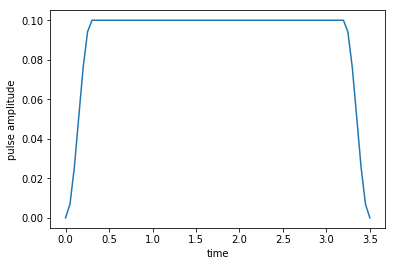

In [8]:
def plot_pulse(pulse, tlist):
    fig, ax = plt.subplots()
    if callable(pulse):
        pulse = np.array([pulse(t, args=None) for t in tlist])
    ax.plot(tlist, pulse)
    ax.set_xlabel('time')
    ax.set_ylabel('pulse amplitude')
    plt.show(fig)
    
plot_pulse(H[1][1], tlist)

Then, we solve the equation of motion for the defined objective, which
contains the initial state $\ket{\Psi_{\init}}$ and the Hamiltonian $\op{H}(t)$
defining its evolution. To this end, we have to define the projectors $\op{P}_0 = \ket{0}\bra{0}$ and $\op{P}_1 = \ket{1}\bra{1}$ to compute their expecatation values. Afterwards, we plot the dynamics in a simple plot. It would also be possible to use the Bloch sphere representation.

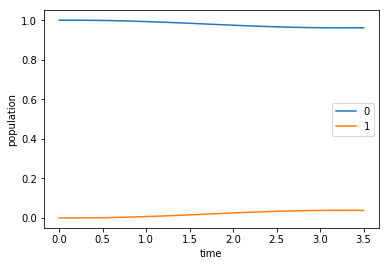

In [9]:
proj0 = psi0 * psi0.dag()
proj1 = psi1 * psi1.dag()

guess_dynamics = objectives[0].mesolve(tlist, e_ops=[proj0, proj1])

def plot_population(result):
    fig, ax = plt.subplots()
    ax.plot(result.times, result.expect[0], label='0')
    ax.plot(result.times, result.expect[1], label='1')
    ax.legend()
    ax.set_xlabel('time')
    ax.set_ylabel('population')
    plt.show(fig)
    
plot_population(guess_dynamics)

## Optimization

In the following we optimize the guess field $\epsilon_{0}(t)$ such
that the intended state-to-state transfer $\ket{\Psi_{\init}} \rightarrow
\ket{\Psi_{\tgt}}$ is solved.
To this end, we
choose the functional to be $F = F_{re}$ with
\begin{equation}
F_{re}
=
\Re\Braket{\Psi(T)}{\Psi_{\tgt}}
\end{equation}

with
$\ket{\Psi(T)}$ the
forward propagated state of $\ket{\Psi_{\init}}$.

In [23]:
oct_result = krotov.optimize_pulses(
    objectives,
    pulse_options=pulse_options,
    tlist=tlist,
    propagator=krotov.propagators.expm,
    chi_constructor=krotov.functionals.chis_re,
    info_hook=krotov.info_hooks.print_table(
        J_T=krotov.functionals.J_T_re,
        show_g_a_int_per_pulse=False,
        unicode=False,
    ),
    check_convergence=krotov.convergence.Or(
        krotov.convergence.value_below(1e-2, name='J_T'),
        krotov.convergence.check_monotonic_error,
        ),
    iter_stop=50,
)

  iter.        J_T     g_a_int          J  Delta_J_T    Delta J  secs
      0   1.00e+00    0.00e+00   1.00e+00        n/a        n/a     0
      1   8.87e-01    7.72e-03   8.95e-01  -1.13e-01  -1.05e-01     0
      2   7.77e-01    7.51e-03   7.84e-01  -1.10e-01  -1.02e-01     0
      3   6.73e-01    7.09e-03   6.80e-01  -1.04e-01  -9.68e-02     0
      4   5.78e-01    6.53e-03   5.84e-01  -9.56e-02  -8.91e-02     0
      5   4.92e-01    5.86e-03   4.98e-01  -8.58e-02  -8.00e-02     0
      6   4.16e-01    5.14e-03   4.21e-01  -7.54e-02  -7.03e-02     0
      7   3.51e-01    4.43e-03   3.56e-01  -6.51e-02  -6.07e-02     0
      8   2.96e-01    3.76e-03   3.00e-01  -5.53e-02  -5.15e-02     0
      9   2.50e-01    3.15e-03   2.53e-01  -4.63e-02  -4.32e-02     0
     10   2.11e-01    2.61e-03   2.14e-01  -3.85e-02  -3.59e-02     0
     11   1.79e-01    2.14e-03   1.82e-01  -3.17e-02  -2.95e-02     0
     12   1.53e-01    1.75e-03   1.55e-01  -2.59e-02  -2.41e-02     0
     13   1.32e-01  

## Simulate dynamics of the optimized field

Having obtained the optimized
control field, we can now
plot it and calculate the
population dynamics under
this field.

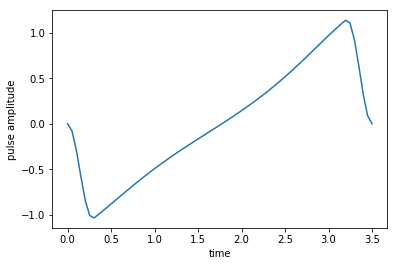

/home/sabrina/anaconda3/envs/qucontrolenv/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /home/sabrina/qusco_school_2019/notebooks/rhs104571.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


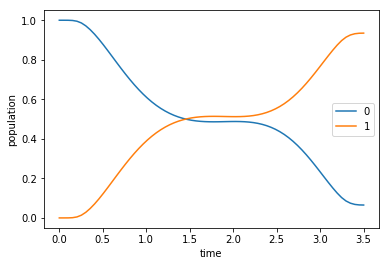

In [24]:
plot_pulse(oct_result.optimized_controls[0], tlist)

opt_dynamics = oct_result.optimized_objectives[0].mesolve(
    tlist, e_ops=[proj0, proj1])
plot_population(opt_dynamics)

# Tasks

1) Vary the numerical parameters `lambda_a` and $n_{t}$ to improve the optimization. You should be able to reach the desired fidelity of 99% within less than 50 iterations. 

2) Try to improve the guess pulse to converge faster. Hint: The interesting parameters are `ampl0` and $T$/`t_stop` (Keep in mind to change it in the shape $S$ and in the time grid `tlist`). Also, a constant pulse might not be the best option as a guess pulse.